In [1]:
import numpy as np
import matplotlib.pyplot as plt

# non-linear least-squares fitting is a case of optimization problem
# The de-facto standard optimization package is called 'scipy.optimize'
import scipy.optimize as opt

# Example data

Let's create some fake experimental data. 

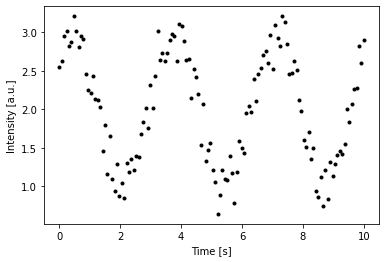

In [2]:
A, B, C, D = 1, 1.2, 0.8, 2

time = np.linspace(0, 10, 128)
y = A * np.sin(B * time * np.pi/2 + C) + D
y += 0.2 * A * np.random.normal(size = y.shape)

plt.figure()
plt.plot(time, y, '.k')
plt.xlabel('Time [s]')
plt.ylabel('Intensity [a.u.]')
plt.show()

# Modeling our data

In order to fit, we need a model to verify. Let's say that, for our fake experiment, we expect our data to look like:

$$
    y(t) = A e^{-\gamma/2}\sin(\frac{\pi}{2} B t + C) + D
$$

We need to create a Python function that follows that model.

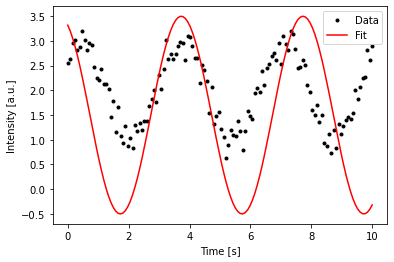

In [3]:
# Side note: Python models for data must always have the independent
#            variable as the first function variable. Then,
#            fitting parameters (A, B, C, ...) follow.
def model(t, A, B, C, D):
    return A * np.sin( B * t * np.pi / 2 + C) + D


# Trying out a few parameters
# A = 2
# B = 1
# C = 2
# D = 1.5

plt.figure()
plt.plot(time, y, '.k', label = 'Data')
plt.plot(time, model(time, 2,1,2,1.5), 'r-', label = 'Fit')
plt.xlabel('Time [s]')
plt.ylabel('Intensity [a.u.]')
plt.legend()
plt.show()

# Non-linear least-squares fitting: `scipy.optimize.curve_fit`

The most general 1D non-linear least-squares fitting function is `scipy.optimize.curve_fit`. Let's take a look at its documentation:

In [4]:
help(opt.curve_fit)

Help on function curve_fit in module scipy.optimize.minpack:

curve_fit(f, xdata, ydata, p0=None, sigma=None, absolute_sigma=False, check_finite=True, bounds=(-inf, inf), method=None, jac=None, **kwargs)
    Use non-linear least squares to fit a function, f, to data.
    
    Assumes ``ydata = f(xdata, *params) + eps``.
    
    Parameters
    ----------
    f : callable
        The model function, f(x, ...). It must take the independent
        variable as the first argument and the parameters to fit as
        separate remaining arguments.
    xdata : array_like or object
        The independent variable where the data is measured.
        Should usually be an M-length sequence or an (k,M)-shaped array for
        functions with k predictors, but can actually be any object.
    ydata : array_like
        The dependent data, a length M array - nominally ``f(xdata, ...)``.
    p0 : array_like, optional
        Initial guess for the parameters (length N). If None, then the
        initi

That is very thorough! It even shows examples at the bottom!

Things to note :
* First argument is a `callable`. This means that the first argument of `scipy.optimize.curve_fit` should be a function - this is precisely the model we defined above.
* Second and third parameters (`xdata` and `ydata`) are your data points. `xdata` is the independent variable (in our case, `time`).
* Fourth parameter (`p0`) is a list of initial values for the fitting parameters. Since our model has four parameters (`A`, `B`, `C`, and `D`), `p0` will be a list of four values. Most of the time, the initial parameters are not important.
* `scipy.optimize.curve_fit` returns __two__ things: the optimal parameters (`popt`) and the covariance matrix (`pcov`). Both will be useful!

Let's look at an example:

Best fit parameters: 
 [0.97995435 1.20200622 0.76768832 2.00358086]
Covariance matrix: 
 [[ 5.84624447e-04  3.88722871e-07 -8.79435510e-06 -4.08826696e-06]
 [ 3.88722871e-07  3.03453540e-05 -2.50446011e-04 -1.71625736e-05]
 [-8.79435510e-06 -2.50446011e-04  2.67571617e-03  1.37683031e-04]
 [-4.08826696e-06 -1.71625736e-05  1.37683031e-04  3.02005849e-04]]


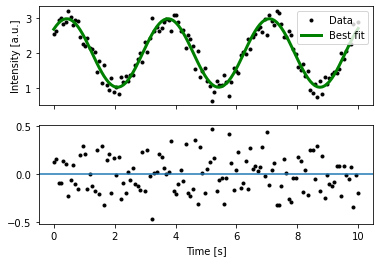

In [5]:
best_params, cov_matrix = opt.curve_fit(model, xdata = time, ydata = y, 
                                   p0 = [2, 1, 2, 1.5])

print('Best fit parameters: \n', best_params)
print('Covariance matrix: \n', cov_matrix)

# Based on the best fit parameters, we can generate
# a curve called `best_fit`
best_A, best_B, best_C, best_D = best_params
best_fit = model(time, best_A, best_B, best_C, best_D)

# Plotting the resulting fit to see if it makes sense
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True)

ax1.plot(time, y, '.k', label = 'Data')
ax1.plot(time, best_fit, 'g-', linewidth = 3, label = 'Best fit')

ax2.plot(time, best_fit - y, '.k')
ax2.axhline(y = 0)


ax2.set_xlabel('Time [s]')
ax1.set_ylabel('Intensity [a.u.]')
ax1.legend()
plt.show()

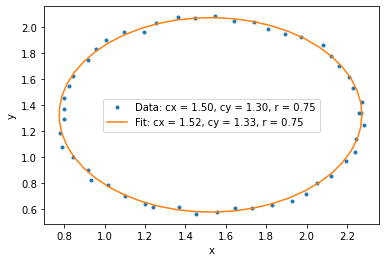

In [6]:
def s(theta, t):
    x = theta[0] + theta[2] * np.cos(t)
    y = theta[1] + theta[2] * np.sin(t)
    return np.array([x, y])

ts = np.linspace(0, 2 * np.pi)
cx = 1.5; cy = 1.3; r = 0.75; noise = 0.05
ss = s([cx, cy, r], ts)
ss[0] += noise * np.random.rand(ts.shape[0])
ss[1] += noise * np.random.rand(ts.shape[0])
#1 - N are m_x-dx and N+1-2N are m_y-dy
def fun(theta):
    return (s(theta, ts) - ss).flatten()

theta0 = [0,0,0]

res2 = opt.least_squares(fun, theta0)
lsq = s(res2.x,np.linspace(0,2*np.pi))
fig, ax = plt.subplots(1,1)
ax.plot(ss[0], ss[1], '.', label = f'Data: cx = {cx:.2f}, cy = {cy:.2f}, r = {r:.2f}')
ax.plot(lsq[0],lsq[1],'-', label = f'Fit: cx = {res2.x[0]:.2f}, cy = {res2.x[1]:.2f}, r = {res2.x[2]:.2f}')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()
plt.show()

## $y(t) = \frac{K}{1+e^{-r(t-t_0)}}$

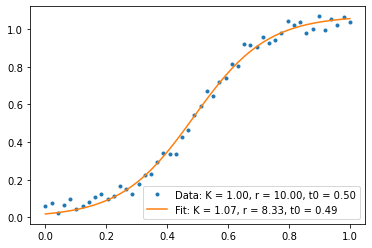

In [7]:
def y(theta, t):
    return theta[0] / (1 + np.exp(- theta[1] * (t - theta[2])))

ts = np.linspace(0, 1)
K = 1; r = 10; t0 = 0.5; noise = 0.1
ys = y([K, r, t0], ts) + noise * np.random.rand(ts.shape[0])

def fun(theta):
    return y(theta, ts) - ys

theta0 = [1,2,3]
res1 = opt.least_squares(fun, theta0)
fig, ax = plt.subplots(1,1)
ax.plot(ts, ys, '.', label = f'Data: K = {K:.2f}, r = {r:.2f}, t0 = {t0:.2f}')
ax.plot(ts, y(res1.x, ts), '-', label=f'Fit: K = {res1.x[0]:.2f}, r = {res1.x[1]:.2f}, t0 = {res1.x[2]:.2f}')
ax.legend()
plt.show()

# Lets do a 2D example
$h(x,y) = \sin\big\{\sqrt{A(x-x_0)^2+B(y-y_0)^2}\big\} $

Text(0.5, 0.92, 'x0 = 0.13, y0 = -0.15, a = 0.92, b = 2.18')

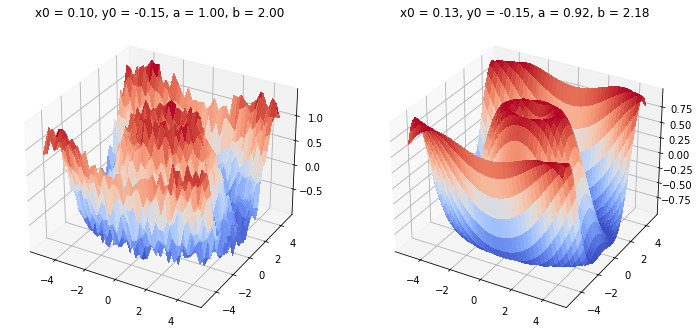

In [8]:
from mpl_toolkits import mplot3d 
from matplotlib import cm
from matplotlib.ticker import LinearLocator

def h(theta, x, y):
    R = np.sqrt(theta[2]*(x-theta[0])**2 + theta[3]*(y-theta[1])**2)
    return np.sin(R)

X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
x0 = 0.1; y0 = -0.15; a = 1; b = 2; noise = 0.1
hs = h([x0, y0, a, b], X, Y)
hs +=  0.5*np.random.default_rng().random(hs.shape)

def fun(theta):
    return (h(theta, X, Y) - hs).flatten()

theta0 = [0, 0, 1, 2]
res3 = opt.least_squares(fun, theta0)

fig, (ax1, ax2) = plt.subplots(1,2,subplot_kw={"projection": "3d"}, figsize=(12,8))

surf = ax1.plot_surface(X, Y, hs, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
ax1.set_title(f"x0 = {x0:.2f}, y0 = {y0:.2f}, a = {a:.2f}, b = {b:.2f}")
ax2.plot_surface(X,Y,h(res3.x,X,Y),cmap=cm.coolwarm,linewidth=0,antialiased=False)
ax2.set_title(f"x0 = {res3.x[0]:.2f}, y0 = {res3.x[1]:.2f}, a = {res3.x[2]:.2f}, b = {res3.x[3]:.2f}")

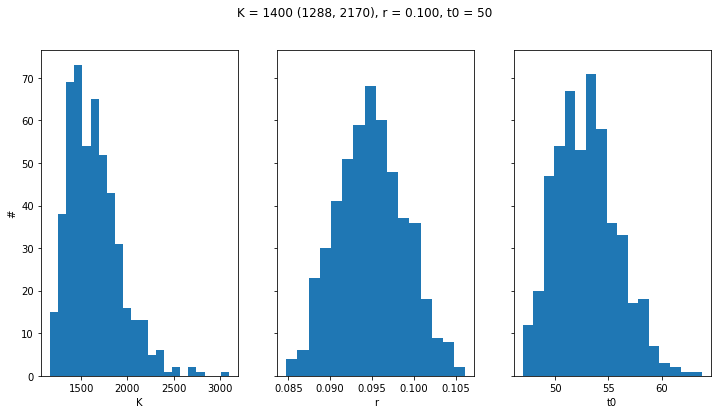

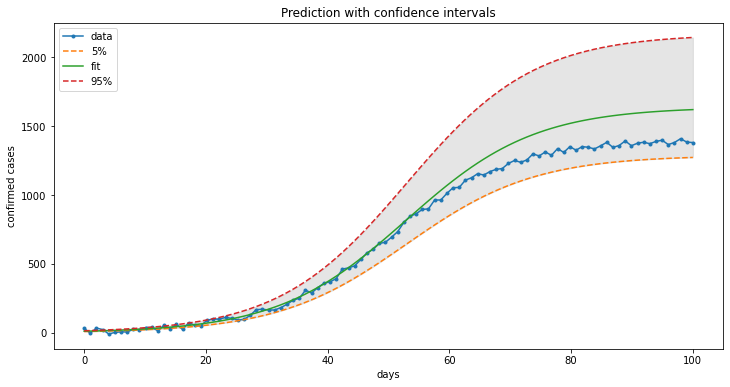

In [9]:
# real data
ts = np.linspace(0, 100, 100)
K = 1400; r = 0.1; t0 = 50; noise = 50
ys = y([K, r, t0], ts) + noise * (np.random.rand(ts.shape[0]) - 0.5)

# again, we only use the first 50% of the data
train_limit = 50 # out of 100 datapoints
def fun(theta):
    return y(theta, ts[:train_limit]) - ys[:train_limit]

# run the parameter estimation
theta0 = [1000, 0.1, 30]
initial_res = opt.least_squares(fun, theta0)

# use the residuals to estimate the error distribution
eps = initial_res.fun

# residual resampling
M = 500 # number of resamples
theta_est = []
for _ in range(M):
    # generate synthetic sample
    fit_ys = y(initial_res.x, ts[:train_limit])
    np.random.default_rng().shuffle(eps)
    synthetic_ys = fit_ys + eps
    
    # fit the model again
    res = opt.least_squares(lambda theta: y(theta, ts[:train_limit]) - synthetic_ys[:train_limit], theta0)
    theta_est.append(res.x)

Ks, rs, t0s = np.array(theta_est).transpose()
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(12,6), sharey=True)
ax1.hist(Ks,bins='auto')
ax1.set_ylabel("#")
ax1.set_xlabel("K")
ax2.hist(rs,bins='auto')
ax2.set_xlabel("r")
ax3.hist(t0s,bins='auto')
ax3.set_xlabel("t0")
K05, K95 = np.quantile(Ks, [0.05, 0.95])

fig.suptitle(f'K = {K:.0f} ({K05:.0f}, {K95:.0f}), r = {r:.3f}, t0 = {t0:.0f}')
plt.show()
K = Ks.mean()
r = rs.mean()
t0 = t0s.mean()

y05 = y([K05, r, t0], ts)
y95 = y([K95, r, t0], ts)

fig = plt.figure(figsize = (12, 6))
ax = fig.add_subplot(111)
ax.plot(ts, ys, '.-', label = 'data')
ax.plot(ts, y05, '--', label = '5%')
ax.plot(ts, y([K, r, t0], ts), label = 'fit')
ax.plot(ts, y95, '--', label = '95%')
ax.fill_between(ts, y05, y95, alpha = 0.2, color = 'gray')
ax.set_xlabel('days')
ax.set_ylabel('confirmed cases')
ax.set_title('Prediction with confidence intervals')
ax.legend()
plt.show()